In [2]:
import pandas as pd

In [3]:
df_mra = pd.read_csv('/content/drive/MyDrive/food-cost-planner Project/prediction_price/national_MRA_clean.csv')

##Data Preprocessing Class (Preprocessor)

In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

class Preprocessor:
    def __init__(self, filepath):
        self.data = pd.read_csv(filepath)
        self.product_encoder = LabelEncoder()
        self.category_encoder = LabelEncoder()
        self.product_mapping = None
        self.category_mapping = None

    def remove_outliers(self, column):
        Q1 = self.data[column].quantile(0.25)
        Q3 = self.data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        self.data = self.data[(self.data[column] >= lower_bound) & (self.data[column] <= upper_bound)]
        print(f"Outliers removed from {column}")

    def encode_categorical(self):
        self.data['product_encoded'] = self.product_encoder.fit_transform(self.data['product'])
        self.data['category_encoded'] = self.category_encoder.fit_transform(self.data['category'])
        self.product_mapping = dict(zip(self.product_encoder.classes_, self.product_encoder.transform(self.product_encoder.classes_)))
        self.category_mapping = dict(zip(self.category_encoder.classes_, self.category_encoder.transform(self.category_encoder.classes_)))
        print("Categorical variables encoded.")

    def convert_to_datetime(self, column):
        self.data[column] = pd.to_datetime(self.data[column])
        print(f"Converted {column} to datetime format.")

    def extract_date_features(self, column):
        self.data['year'] = self.data[column].dt.year
        self.data['month'] = self.data[column].dt.month
        self.data['day'] = self.data[column].dt.day
        print(f"Extracted date features from {column}.")

    def show_insights(self):
        print(self.data.head())
        print("\nData Types:\n", self.data.dtypes)
        print("\nMissing Values:\n", self.data.isnull().sum())

    def get_preprocessed_data(self):
        return self.data

    def get_mappings(self):
        return self.product_mapping, self.category_mapping


## next code is used to run the preprossed data and also to get mappings of each product and category that has been hard coded

In [5]:

# Initialize and run the preprocessor
preprocessor = Preprocessor('/content/drive/MyDrive/food-cost-planner Project/prediction_price/national_MRA_clean.csv')  # Replace with your actual file path
preprocessor.remove_outliers('price')
preprocessor.encode_categorical()
preprocessor.convert_to_datetime('date')
preprocessor.extract_date_features('date')

# Get the preprocessed data
preprocessed_data = preprocessor.get_preprocessed_data()

# Extract the mappings
product_mapping, category_mapping = preprocessor.get_mappings()

#  print  mappings
print("Product Mapping:", product_mapping)
print("Category Mapping:", category_mapping)

#


Outliers removed from price
Categorical variables encoded.
Converted date to datetime format.
Extracted date features from date.
Product Mapping: {'Apple juice': 0, 'Apples': 1, 'Bacon': 2, 'Baked beans, canned': 3, 'Bananas': 4, 'Blade roast': 5, 'Bread': 6, 'Butt roast': 7, 'Butter': 8, 'Cabbage': 9, 'Canned salmon': 10, 'Carrots': 11, 'Celery': 12, 'Chicken': 13, 'Coffee, instant': 14, 'Coffee, roasted': 15, 'Cooking or salad oil': 16, 'Corn flakes': 17, 'Eggs': 18, 'Evaporated milk': 19, 'Flour': 20, 'French fried potatoes, frozen': 21, 'Fruit flavoured crystals': 22, 'Grapefruits': 23, 'Ground beef': 24, 'Homogenized milk': 25, 'Ketchup': 26, 'Macaroni': 27, 'Mushrooms': 28, 'Onions': 29, 'Orange juice': 30, 'Oranges': 31, 'Partly skimmed milk': 32, 'Peanut butter': 33, 'Pork chops': 34, 'Potatoes': 35, 'Processed cheese slices': 36, 'Round steak': 37, 'Soda crackers': 38, 'Soft drinks, cola type': 39, 'Soft drinks, lemon-lime type': 40, 'Soup, canned': 41, 'Stewing beef': 42, 'Su

##Model Training and Testing Class (ModelTrainer)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score


class ModelTrainer:
    def __init__(self, data, features, target):
        self.data = data
        self.features = features
        self.target = target
        self.model = DecisionTreeRegressor()

    def split_data(self):
        train_data = self.data[self.data['date'].dt.year <= 2020]
        test_data = self.data[self.data['date'].dt.year > 2020]
        self.X_train = train_data[self.features]
        self.y_train = train_data[self.target]
        self.X_test = test_data[self.features]
        self.y_test = test_data[self.target]
        print("Data split into training and testing sets.")

    def train_and_evaluate(self):
        self.model.fit(self.X_train, self.y_train)
        predictions = self.model.predict(self.X_test)

        mse = mean_squared_error(self.y_test, predictions)
        rmse = mse ** 0.5
        mae = mean_absolute_error(self.y_test, predictions)
        r2 = r2_score(self.y_test, predictions)

        print(f"Model RMSE: {rmse}")
        print(f"Model MAE: {mae}")
        print(f"Model R-squared: {r2}")


#usage

features = ['year', 'month', 'day', 'product_encoded', 'unit_quantity', 'category_encoded']
target = 'price'
trainer = ModelTrainer(preprocessed_data, features, target)
trainer.split_data()  # Splitting the data
trainer.train_and_evaluate()



Data split into training and testing sets.
Model RMSE: 0.32921161956472844
Model MAE: 0.2170746887966805
Model R-squared: 0.9711869019565571


##Predicting Prices for 2023 (triying to get good results)

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from datetime import datetime

class ModelPredictor:
    def __init__(self, model, data, features, categories):
        self.model = model
        self.data = data
        self.features = features
        self.categories = categories

    def generate_2023_data(self):
        # Generate feature data for 2023
        df_2023 = pd.DataFrame(product(pd.date_range('2023-01-01', '2023-12-31', freq='D'),
                                       self.data['product_encoded'].unique(),
                                       self.data['unit_quantity'].unique(),
                                       self.data['category_encoded'].unique()),
                               columns=['date', 'product_encoded', 'unit_quantity', 'category_encoded'])

        # Decompose date into year, month, and day
        df_2023['year'] = df_2023['date'].dt.year
        df_2023['month'] = df_2023['date'].dt.month
        df_2023['day'] = df_2023['date'].dt.day

        return df_2023

    def predict_prices(self):
        df_2023 = self.generate_2023_data()
        df_2023 = df_2023[self.features]
        predicted_prices = self.model.predict(df_2023)
        df_2023['predicted_price'] = predicted_prices
        return df_2023

    def display_predicted_prices_table(self, predictions):
        # Displaying predicted prices in a table format
        average_prices = predictions.groupby(['year','month','day','product_encoded', 'unit_quantity', 'category_encoded'])['predicted_price'].mean().reset_index()
        print("Average Predicted Prices for Each Product in 2023:")
        display(average_prices)

# Usage
predictor = ModelPredictor(trainer.model, preprocessed_data, features, preprocessed_data['category_encoded'].unique())
predictions_2023 = predictor.predict_prices()
predictor.display_predicted_prices_table(predictions_2023)


Average Predicted Prices for Each Product in 2023:


,year,month,day,product_encoded,unit_quantity,category_encoded,predicted_price
0,2023,1,1,0,1.0,0,2.27
1,2023,1,1,0,1.0,1,2.27
2,2023,1,1,0,1.0,2,2.27
3,2023,1,1,0,1.0,3,2.27
4,2023,1,1,0,1.0,4,2.27
...,...,...,...,...,...,...,...
3153595,2023,12,31,47,796.0,4,3.48
3153596,2023,12,31,47,796.0,5,1.29
3153597,2023,12,31,47,796.0,6,1.29
3153598,2023,12,31,47,796.0,7,2.81


In [8]:
predictions_2023.to_csv('/content/drive/MyDrive/food-cost-planner Project/prediction_price/predicted_prices_2023_hajar.csv', index=False)

In [9]:
product_mapping = {
    0: 'Apple juice', 1: 'Apples', 2: 'Bacon', 3: 'Baked beans, canned', 4: 'Bananas',
    5: 'Blade roast', 6: 'Bread', 7: 'Butt roast', 8: 'Butter', 9: 'Cabbage',
    10: 'Canned salmon', 11: 'Carrots', 12: 'Celery', 13: 'Chicken', 14: 'Coffee, instant',
    15: 'Coffee, roasted', 16: 'Cooking or salad oil', 17: 'Corn flakes', 18: 'Eggs',
    19: 'Evaporated milk', 20: 'Flour', 21: 'French fried potatoes, frozen',
    22: 'Fruit flavoured crystals', 23: 'Grapefruits', 24: 'Ground beef',
    25: 'Homogenized milk', 26: 'Ketchup', 27: 'Macaroni', 28: 'Mushrooms', 29: 'Onions',
    30: 'Orange juice', 31: 'Oranges', 32: 'Partly skimmed milk', 33: 'Peanut butter',
    34: 'Pork chops', 35: 'Potatoes', 36: 'Processed cheese slices', 37: 'Round steak',
    38: 'Soda crackers', 39: 'Soft drinks, cola type', 40: 'Soft drinks, lemon-lime type',
    41: 'Soup, canned', 42: 'Stewing beef', 43: 'Sugar, white', 44: 'Tea ',
    45: 'Tomato juice', 46: 'Tomatoes, canned', 47: 'Wieners'
}


In [10]:
import pandas as pd

# Load 2023 predictions dataset
predicted_data_2023 = pd.read_csv("/content/drive/MyDrive/food-cost-planner Project/prediction_price/predicted_prices_2023_hajar.csv")

# Map the encoded values to product names
predicted_data_2023['product_name'] = predicted_data_2023['product_encoded'].map(product_mapping)

# Now, the dataset will have a new column 'product_name' with the decoded product names
print(predicted_data_2023.head())


   year  month  day  product_encoded  unit_quantity  category_encoded  \
0  2023      1    1                5            1.0                 7   
1  2023      1    1                5            1.0                 0   
2  2023      1    1                5            1.0                 1   
3  2023      1    1                5            1.0                 3   
4  2023      1    1                5            1.0                 8   

   predicted_price product_name  
0             8.77  Blade roast  
1             2.87  Blade roast  
2             2.87  Blade roast  
3             2.87  Blade roast  
4             1.55  Blade roast  


In [11]:
predicted_data_2023.to_csv('/content/drive/MyDrive/food-cost-planner Project/prediction_price/predicted_2023_productsNamed_hajar.csv', index=False)

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_originl_data = pd.read_csv('/content/drive/MyDrive/food-cost-planner Project/prediction_price/national_MRA_clean.csv')

predict_named_2023 = pd.read_csv('/content/drive/MyDrive/food-cost-planner Project/prediction_price/predicted_2023_productsNamed_hajar.csv')

# Convert date column to datetime for df_original_data
df_original_data['date'] = pd.to_datetime(df_original_data['date'])

# Filter for January 2022 in the original data
jan_2022 = df_original_data[df_original_data['date'].dt.year == 2022][df_original_data['date'].dt.month == 1]

# Filter for January 2023 in the predicted data
jan_2023_predicted = predict_named_2023[predict_named_2023['date'].dt.year == 2023][predict_named_2023['date'].dt.month == 1]

# Merge the datasets on the product names
merged_data = jan_2023_predicted.merge(jan_2022, left_on='product_name', right_on='product', suffixes=('_predicted', '_actual'))

# Compute the difference in prices
merged_data['price_difference'] = merged_data['price_predicted'] - merged_data['price_actual']

# Display the merged data with the price difference
print(merged_data)




NameError: ignored

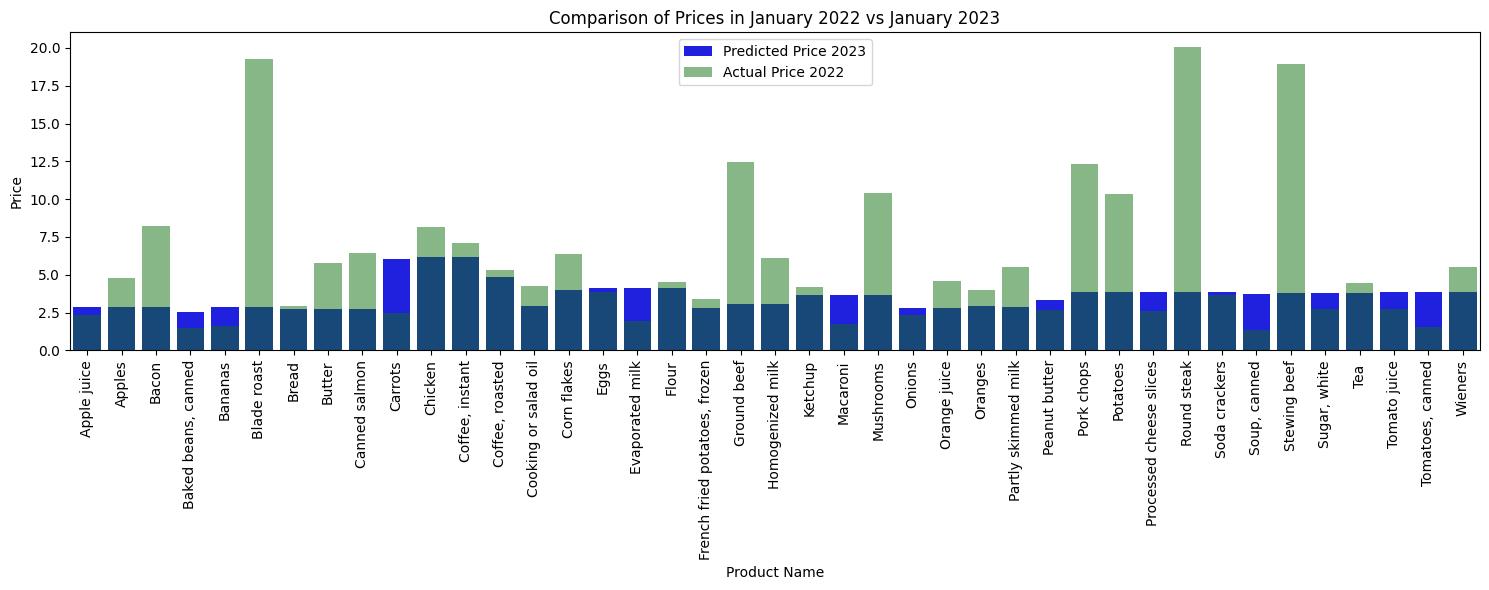

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Paths to your datasets
original_data_path = '/content/drive/MyDrive/food-cost-planner Project/prediction_price/national_MRA_clean.csv'
predicted_data_path = '/content/drive/MyDrive/food-cost-planner Project/prediction_price/predicted_2023_productsNamed_hajar.csv'

# Load the datasets
df_original_data = pd.read_csv(original_data_path)
predict_named_2023 = pd.read_csv(predicted_data_path)

# Convert date column to datetime for df_original_data
df_original_data['date'] = pd.to_datetime(df_original_data['date'])

# Create a 'date' column in predict_named_2023 by combining 'year', 'month', 'day'
predict_named_2023['date'] = pd.to_datetime(predict_named_2023[['year', 'month', 'day']])

# Filter for January 2022 in the original data
jan_2022 = df_original_data[(df_original_data['date'].dt.year == 2022) & (df_original_data['date'].dt.month == 1)]

# Filter for January 2023 in the predicted data
jan_2023_predicted = predict_named_2023[(predict_named_2023['date'].dt.year == 2023) & (predict_named_2023['date'].dt.month == 1)]

# Merge the datasets on the product names
merged_data = jan_2023_predicted.merge(jan_2022, left_on='product_name', right_on='product', suffixes=('_predicted', '_actual'))

# Aggregate data
grouped_data = merged_data.groupby('product_name').agg({
    'predicted_price': 'mean',
    'price': 'mean'  
}).reset_index()

# Plotting
plt.figure(figsize=(15, 6))
sns.barplot(data=grouped_data, x='product_name', y='predicted_price', color='blue', label='Predicted Price 2023')
sns.barplot(data=grouped_data, x='product_name', y='price', color='green', alpha=0.5, label='Actual Price 2022')
plt.xticks(rotation=90)
plt.xlabel('Product Name')
plt.ylabel('Price')
plt.title('Comparison of Prices in January 2022 vs January 2023')
plt.legend()
plt.tight_layout()
plt.show()


###Now, we will load the actual 2023 data sourced from Statistics Canada. This will be compared with our predictions to assess their accuracy and alignment.

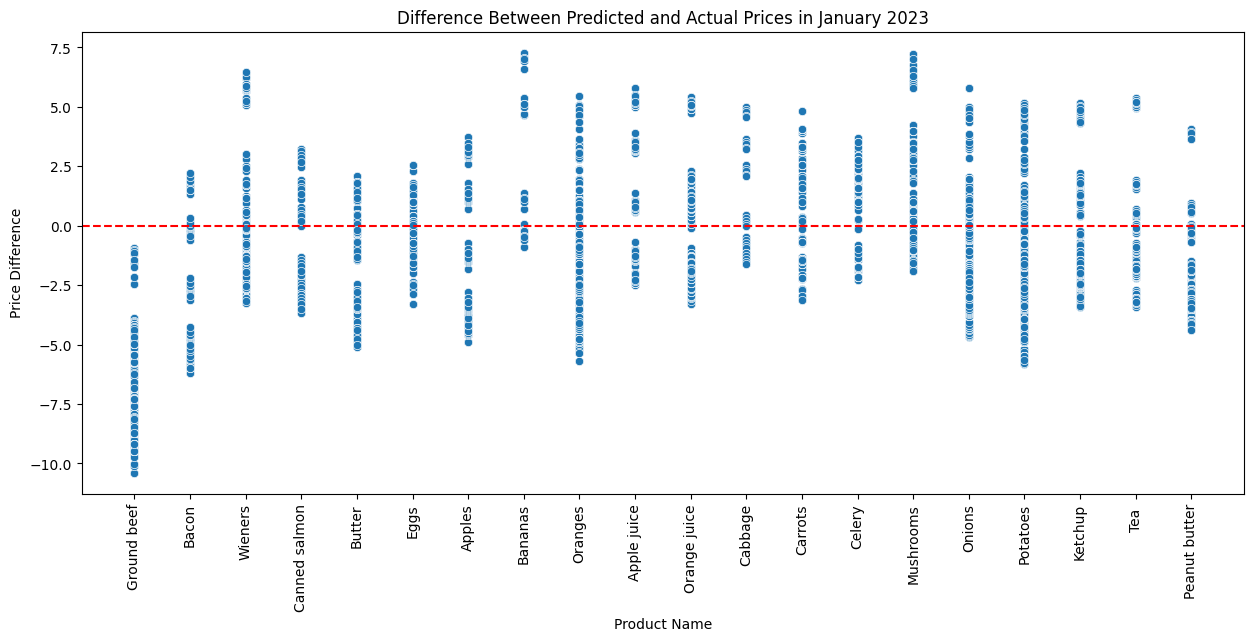

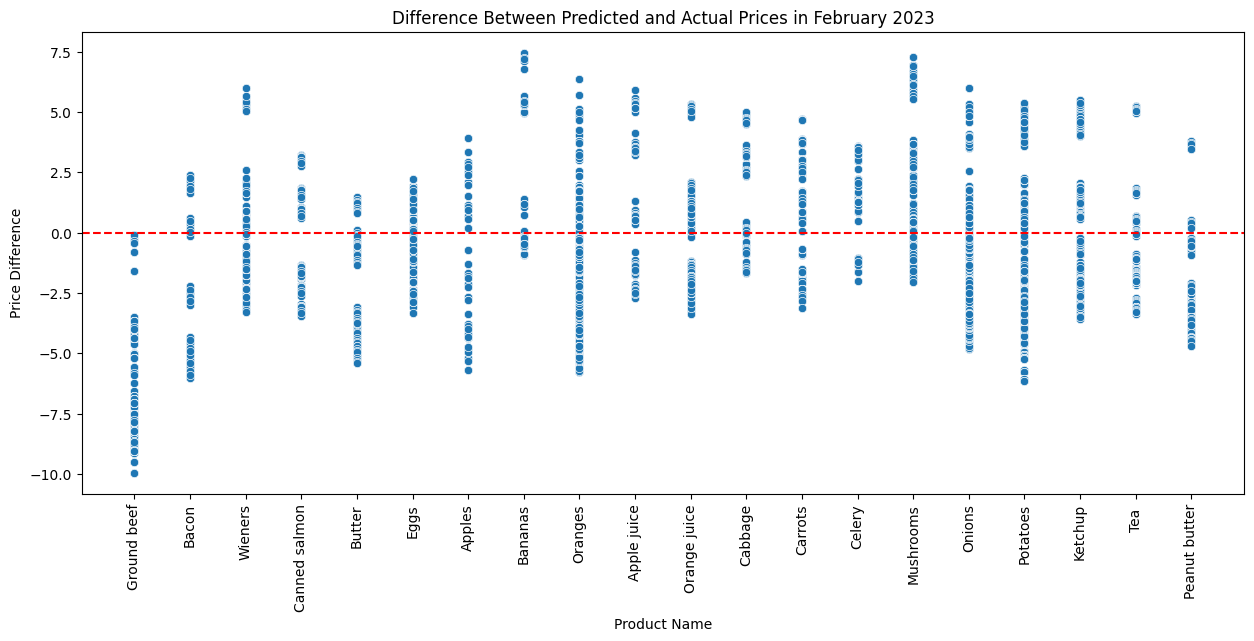

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Paths to datasets
predicted_data_path = '/content/drive/MyDrive/food-cost-planner Project/prediction_price/predicted_2023_productsNamed_hajar.csv'
actual_data_2023_path = '/content/drive/MyDrive/food-cost-planner Project/prediction_price/2023_MRA_clean (1).csv'

# Load the datasets
predicted_2023 = pd.read_csv(predicted_data_path)
actual_2023 = pd.read_csv(actual_data_2023_path)

# Convert date columns to datetime
predicted_2023['date'] = pd.to_datetime(predicted_2023[['year', 'month', 'day']])
actual_2023['date'] = pd.to_datetime(actual_2023['date'])

# Filter for January and February 2023 in both datasets
jan_predicted = predicted_2023[(predicted_2023['date'].dt.month == 1)]
feb_predicted = predicted_2023[(predicted_2023['date'].dt.month == 2)]
jan_actual = actual_2023[(actual_2023['date'].dt.month == 1)]
feb_actual = actual_2023[(actual_2023['date'].dt.month == 2)]

# Merge the datasets for January and February
jan_data = jan_predicted.merge(jan_actual, left_on='product_name', right_on='product', suffixes=('_predicted', '_actual'))
feb_data = feb_predicted.merge(feb_actual, left_on='product_name', right_on='product', suffixes=('_predicted', '_actual'))

# Calculate the difference for January and February
jan_data['price_difference'] = jan_data['predicted_price'] - jan_data['price']
feb_data['price_difference'] = feb_data['predicted_price'] - feb_data['price']

# Plotting the comparison for January
plt.figure(figsize=(15, 6))
sns.scatterplot(data=jan_data, x='product_name', y='price_difference')
plt.xticks(rotation=90)
plt.xlabel('Product Name')
plt.ylabel('Price Difference')
plt.title('Difference Between Predicted and Actual Prices in January 2023')
plt.axhline(0, color='red', linestyle='--')
plt.show()

# Plotting the comparison for February
plt.figure(figsize=(15, 6))
sns.scatterplot(data=feb_data, x='product_name', y='price_difference')
plt.xticks(rotation=90)
plt.xlabel('Product Name')
plt.ylabel('Price Difference')
plt.title('Difference Between Predicted and Actual Prices in February 2023')
plt.axhline(0, color='red', linestyle='--')
plt.show()

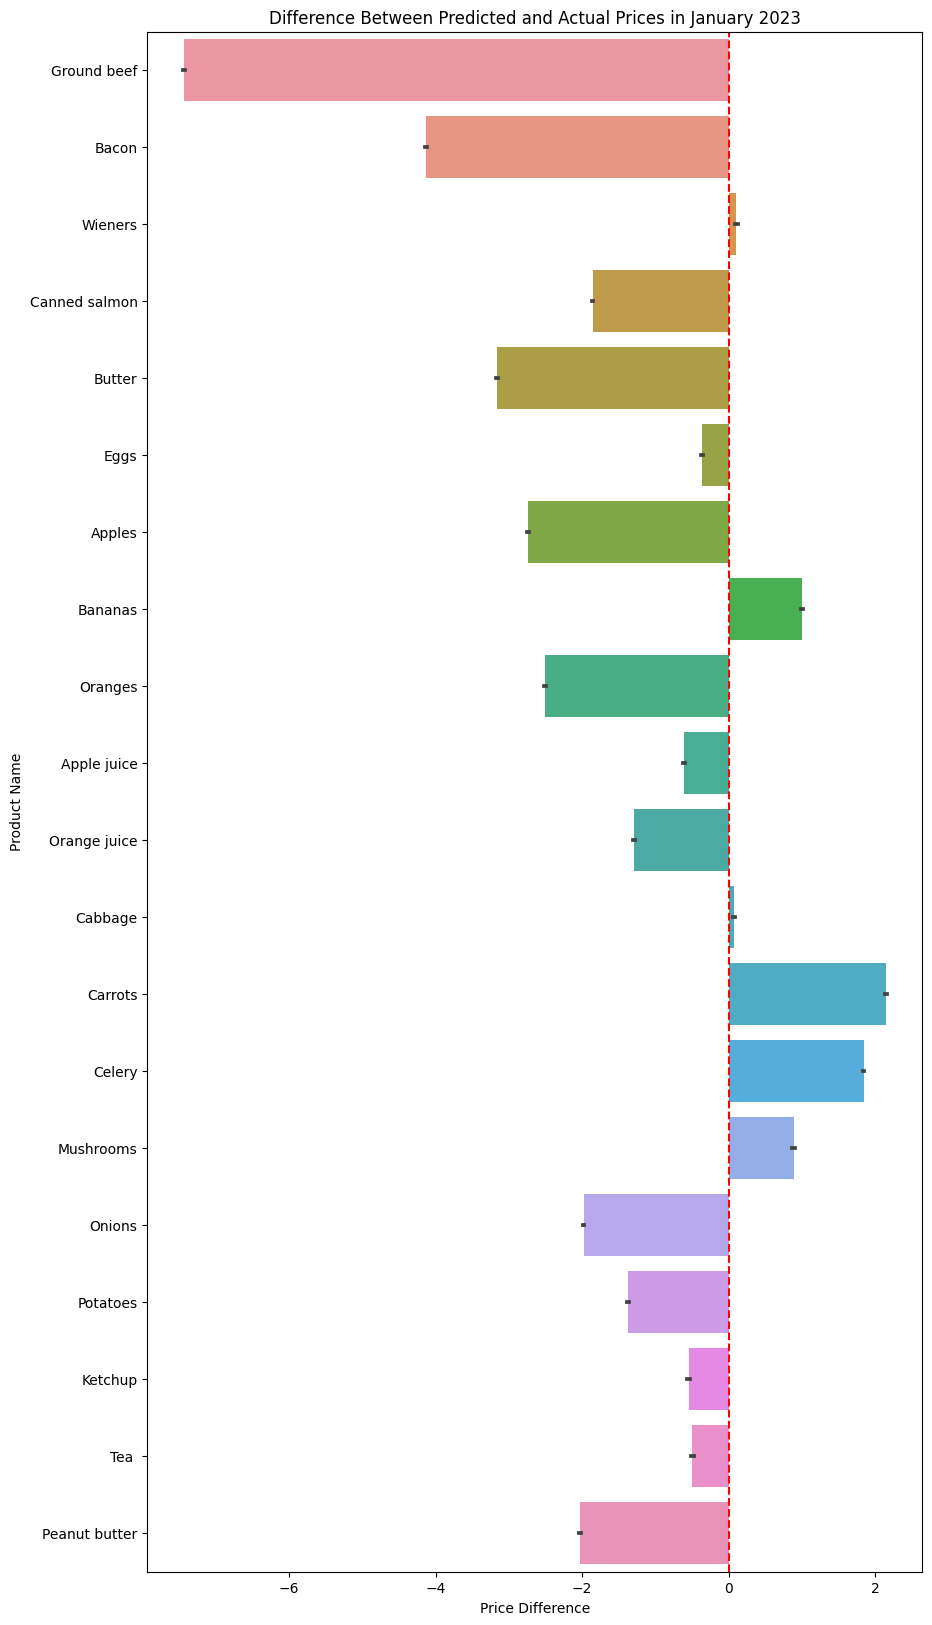

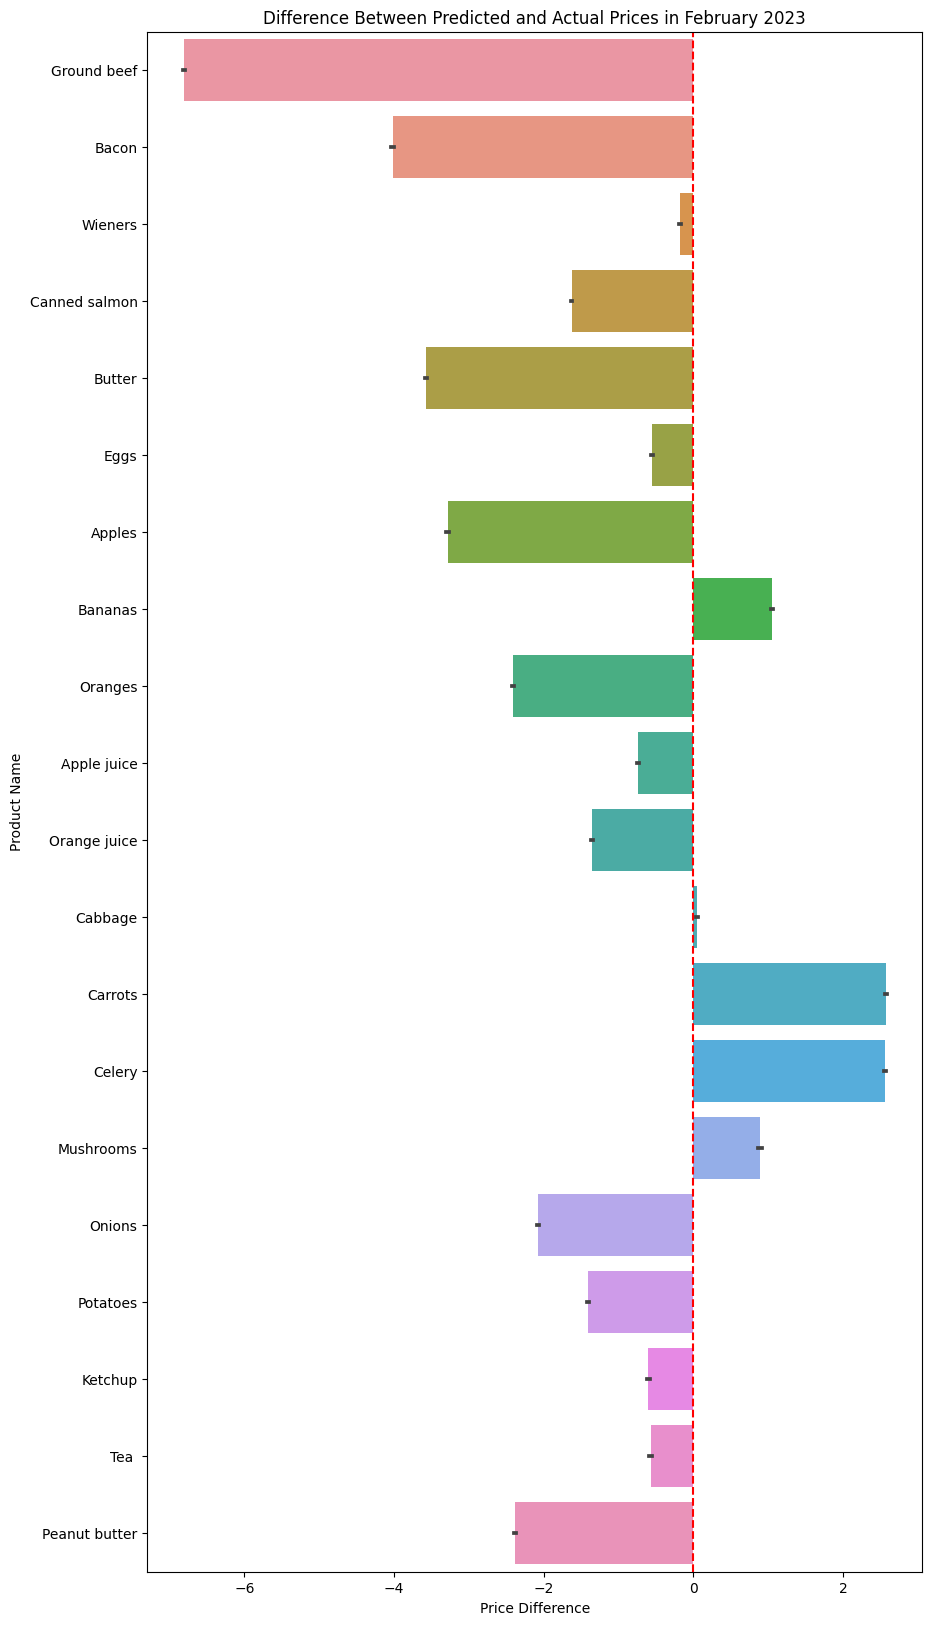

In [5]:
def plot_price_difference(data, month):
    max_height = 20  # Maximum height of the plot
    height_per_product = 0.3  # Height allocated for each product
    num_products = len(data)
    plot_height = min(num_products * height_per_product, max_height)

    plt.figure(figsize=(10, plot_height))
    sns.barplot(data=data, y='product_name', x='price_difference', orient='h')
    plt.xlabel('Price Difference')
    plt.ylabel('Product Name')
    plt.title(f'Difference Between Predicted and Actual Prices in {month} 2023')
    plt.axvline(0, color='red', linestyle='--')  # Line indicating zero difference
    plt.show()

# Plotting the comparison for January and February
plot_price_difference(jan_data, 'January')
plot_price_difference(feb_data, 'February')

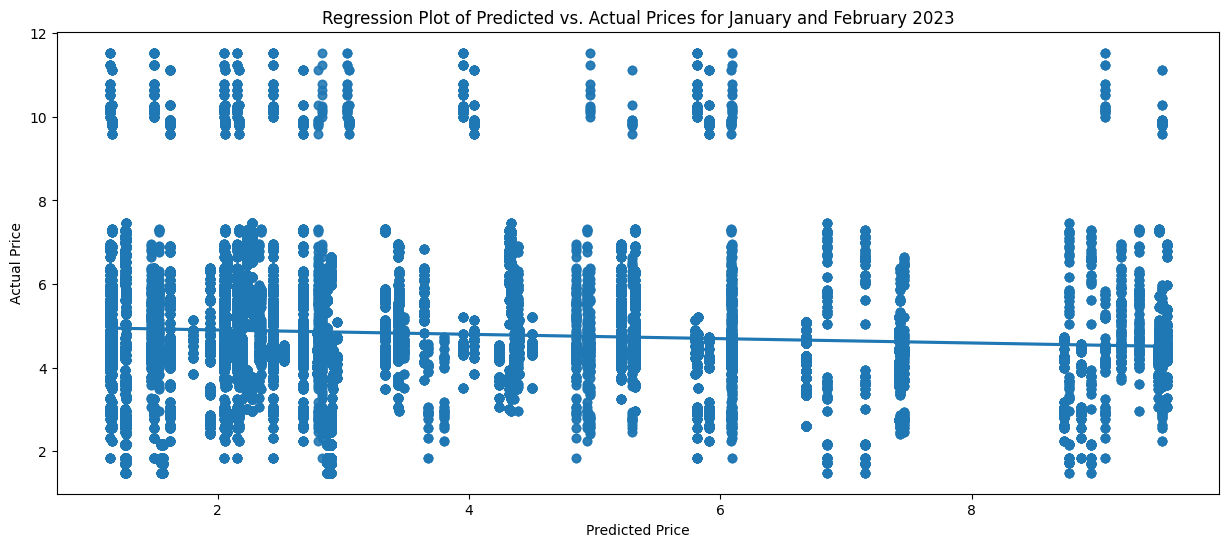

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Paths to your datasets
predicted_data_path = '/content/drive/MyDrive/food-cost-planner Project/prediction_price/predicted_2023_productsNamed_hajar.csv'
actual_data_2023_path = '/content/drive/MyDrive/food-cost-planner Project/prediction_price/2023_MRA_clean (1).csv'

# Load the datasets
predicted_2023 = pd.read_csv(predicted_data_path)
actual_2023 = pd.read_csv(actual_data_2023_path)

# Convert date columns to datetime
predicted_2023['date'] = pd.to_datetime(predicted_2023[['year', 'month', 'day']])
actual_2023['date'] = pd.to_datetime(actual_2023['date'])

# Filter for January and February 2023 in both datasets
jan_feb_predicted = predicted_2023[predicted_2023['date'].dt.month.isin([1, 2])]
jan_feb_actual = actual_2023[actual_2023['date'].dt.month.isin([1, 2])]

# Merge the datasets
merged_data = jan_feb_predicted.merge(jan_feb_actual, left_on=['product_name', 'date'], right_on=['product', 'date'], suffixes=('_predicted', '_actual'))

# Plotting
plt.figure(figsize=(15, 6))
sns.regplot(data=merged_data, x='predicted_price', y='price', scatter_kws={'alpha':0.5})
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Regression Plot of Predicted vs. Actual Prices for January and February 2023')
plt.show()



##Conclusion

####I can summarize by stating that my model is capable of predicting the prices of several items. After comparing these predictions with the actual prices from 2023, it has been observed that the model accurately forecasts the prices of cabbage and wieners, and to a lesser extent, ketchup and tea. This marks a significant improvement, and as with any project, there is ample opportunity to further refine and optimize my model to enhance predictions for additional products